In [1]:
import pandas as pd
import numpy as np

#Khởi chạy dữ liệu 
df = pd.read_csv('framingham.csv')
df = df.drop(columns='education')
# df.head()
print("Thông tin về các trường, kiểu dữ liệu:")
df.info()  
print(f'Thống kê sơ bộ về các trường số:\n {df.describe()}') 
print(f' Hiển thị 5 bản ghi đầu tiên:\n {df.head()}')  

Thông tin về các trường, kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   currentSmoker    4240 non-null   int64  
 3   cigsPerDay       4211 non-null   float64
 4   BPMeds           4187 non-null   float64
 5   prevalentStroke  4240 non-null   int64  
 6   prevalentHyp     4240 non-null   int64  
 7   diabetes         4240 non-null   int64  
 8   totChol          4190 non-null   float64
 9   sysBP            4240 non-null   float64
 10  diaBP            4240 non-null   float64
 11  BMI              4221 non-null   float64
 12  heartRate        4239 non-null   float64
 13  glucose          3852 non-null   float64
 14  TenYearCHD       4240 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 497.0 KB
Thống kê sơ bộ về cá

In [2]:
#Kiểm tra giá trị rỗng 
df.isnull().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [3]:
df.shape

(4240, 15)

In [4]:
# Định nghĩa các cột nhị phân
bin_cols = ["male", "currentSmoker", "prevalentStroke", "prevalentHyp", "diabetes"]

# Điền các giá trị còn thiếu cho các tính năng nhị phân có giá trị thường xuyên nhất (mode)
for col in bin_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Kiểm tra xem có bất kỳ giá trị nào còn thiếu không
# missing_values = df.isnull().sum()

In [5]:
# Điền các giá trị còn thiếu cho các tính năng số
numeric_cols = ["cigsPerDay", "BPMeds", "totChol", "BMI", "heartRate", "glucose"]
for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val)


# Kiểm tra xem có bất kỳ giá trị nào còn thiếu không
# missing_values = df.isnull().sum()

In [6]:
df['TenYearCHD'].value_counts()

TenYearCHD
0    3596
1     644
Name: count, dtype: int64

In [7]:
#giảm chiều PCA 
from sklearn.decomposition import PCA



In [8]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['TenYearCHD'] == 0]
df_minority = df[df['TenYearCHD'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),    # To match majority class
                                 random_state=42) # Reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [9]:
df_balanced['TenYearCHD'].value_counts()

TenYearCHD
0    3596
1    3596
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Separate features (X) and target variable (y)
X = df_balanced.drop(columns=['TenYearCHD'])
y = df_balanced['TenYearCHD']

# Kiểm tra lại NaN
missing_values = df_balanced.isnull().sum()
print(missing_values[missing_values > 0])

# Áp dụng SimpleImputer để điền giá trị NaN còn lại (Hieu sửa để tối ưu)
imputer = SimpleImputer(strategy='median')  # Điền giá trị median cho các cột số
X = imputer.fit_transform(X)

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cigsPerDay     38
BPMeds        124
totChol        76
BMI            54
heartRate       9
glucose       590
dtype: int64


In [11]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define a list of classifiers
classifiers = [
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
]

# Create a dictionary to store the results
results = {}

# 1. Huấn luyện và đánh giá trên dữ liệu không giảm chiều
print("Độ chính xác trên dữ liệu không giảm chiều:")
for clf in classifiers:
    clf_name = clf.__class__.__name__
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    results[clf_name] = {"original_accuracy": accuracy}
    print(f"{clf_name} Accuracy (Original): {accuracy}")

# 2. Giảm chiều dữ liệu xuống 2D bằng PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Huấn luyện và đánh giá trên dữ liệu đã giảm chiều bằng pca
print("\nĐộ chính xác trên dữ liệu đã giảm chiều (PCA):")
for clf in classifiers:
    clf_name = clf.__class__.__name__
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)

    # Tính toán độ chính xác
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    results[clf_name]["pca_accuracy"] = accuracy_pca
    print(f"{clf_name} Accuracy (PCA): {accuracy_pca}")

# 4. Huấn luyện và đánh giá trên dữ liệu đã giảm chiều u-map
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_train_umap = umap_model.fit_transform(X_train_scaled)
X_test_umap = umap_model.transform(X_test_scaled)

# 3. Huấn luyện và đánh giá trên dữ liệu đã giảm chiều bằng UMAP
print("\nĐộ chính xác trên dữ liệu đã giảm chiều (UMAP):")
for clf in classifiers:
    clf_name = clf.__class__.__name__
    clf.fit(X_train_umap, y_train)
    y_pred_umap = clf.predict(X_test_umap)

    # Tính toán độ chính xác
    accuracy_umap = accuracy_score(y_test, y_pred_umap)
    results[clf_name]["umap_accuracy"] = accuracy_umap
    print(f"{clf_name} Accuracy (UMAP): {accuracy_umap}")
# Hiển thị kết quả so sánh 
print("\nSo sánh độ chính xác giữa dữ liệu không giảm chiều và giảm chiều:")
for clf_name, accuracies in results.items():
    print(f"{clf_name}:")
    print(f"  Original Accuracy: {accuracies['original_accuracy']}")
    print(f"  PCA Accuracy: {accuracies['pca_accuracy']}")
    print("="*50)
# # Train and evaluate each classifier
# for clf in classifiers:
#     clf_name = clf.__class__.__name__
#     clf.fit(X_train_scaled, y_train)
#     y_pred = clf.predict(X_test_scaled)
# 
#     # Calculate accuracy
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"{clf_name} Accuracy: {accuracy}")
# 
#     # Classification report
#     print(f"Classification Report for {clf_name}:")
#     print(classification_report(y_test, y_pred))
# 
#     # Confusion matrix
#     print(f"Confusion Matrix for {clf_name}:")
#     print(confusion_matrix(y_test, y_pred))
#     print("="*50)

Độ chính xác trên dữ liệu không giảm chiều:
LogisticRegression Accuracy (Original): 0.6617238183503243
SVC Accuracy (Original): 0.701112140871177
KNeighborsClassifier Accuracy (Original): 0.7752548656163114
DecisionTreeClassifier Accuracy (Original): 0.9170528266913809
GaussianNB Accuracy (Original): 0.5894346617238183

Độ chính xác trên dữ liệu đã giảm chiều (PCA):
LogisticRegression Accuracy (PCA): 0.6251158480074143
SVC Accuracy (PCA): 0.6260426320667285
KNeighborsClassifier Accuracy (PCA): 0.7701575532900834
DecisionTreeClassifier Accuracy (PCA): 0.91241890639481
GaussianNB Accuracy (PCA): 0.6204819277108434


AttributeError: module 'umap' has no attribute 'UMAP'

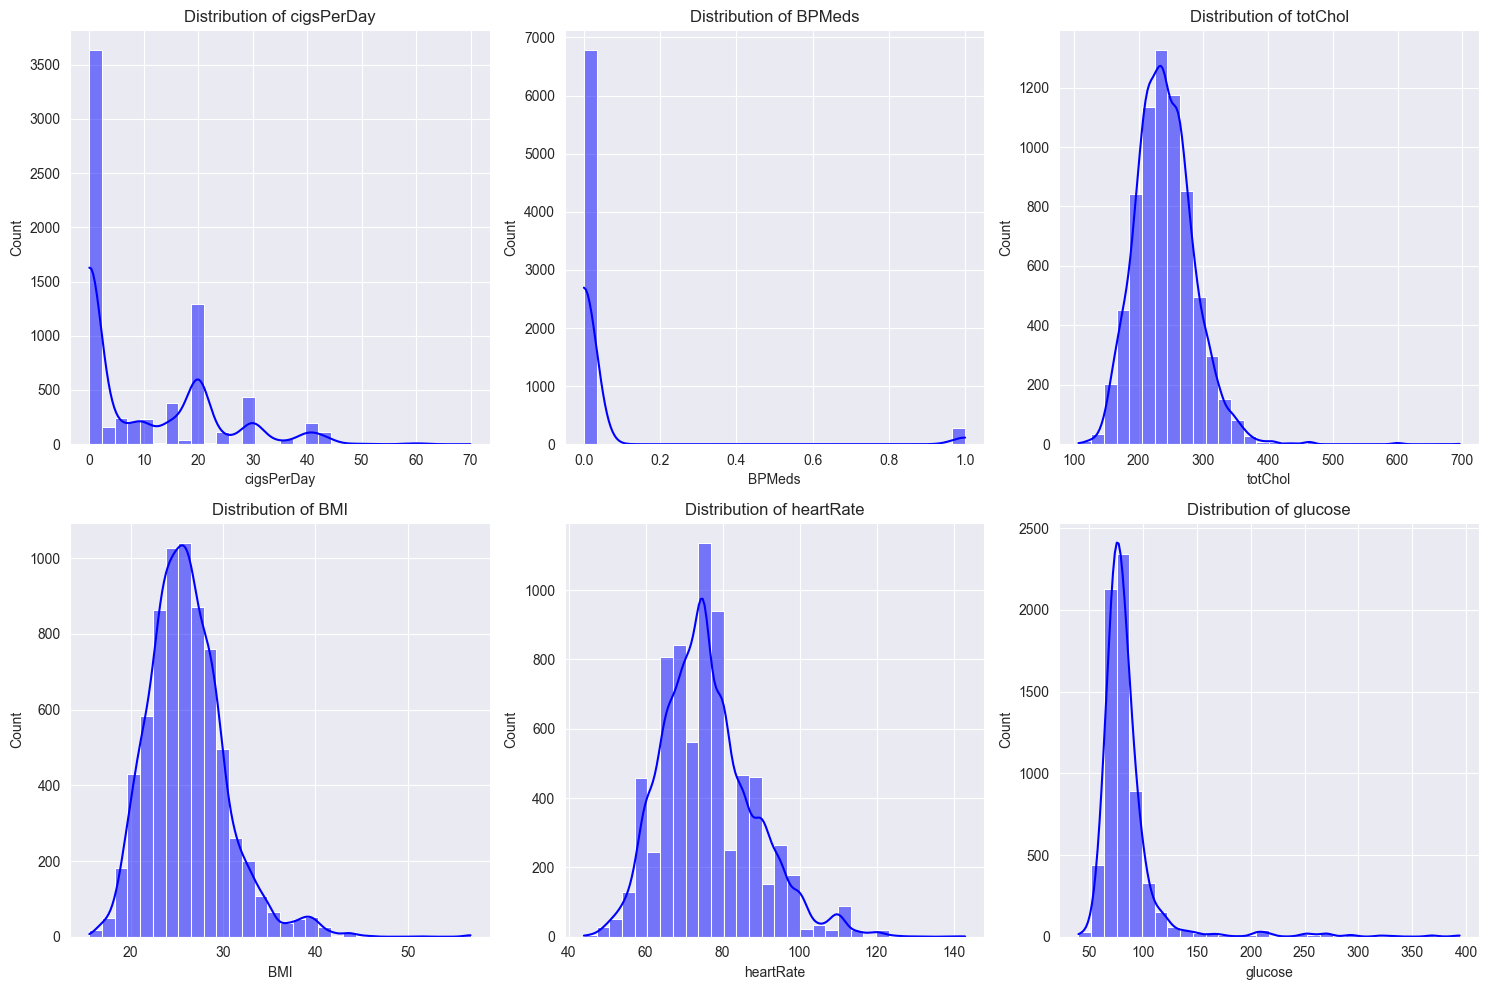

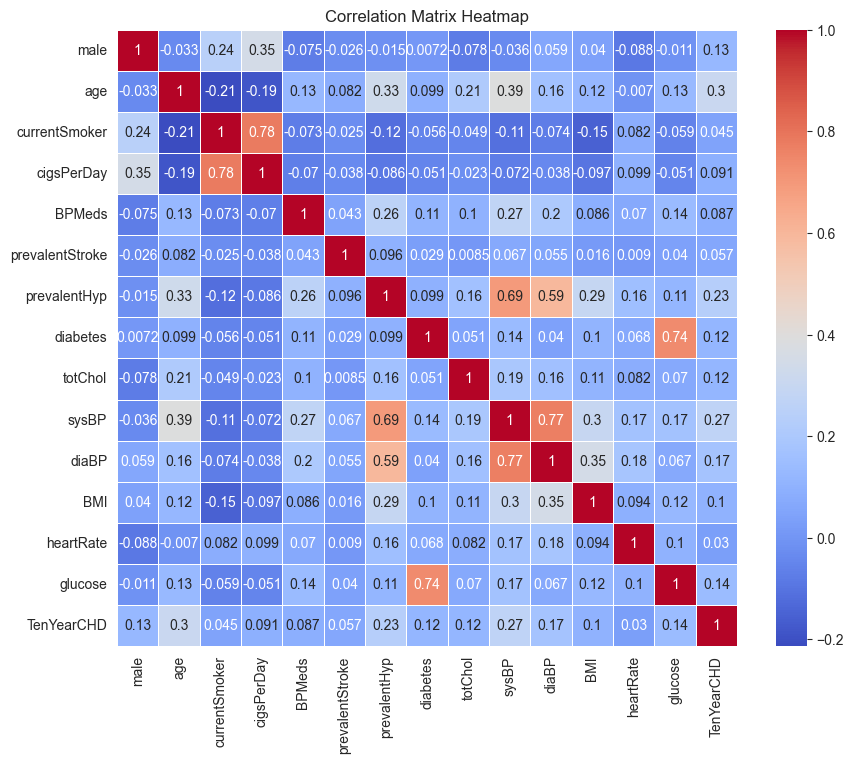

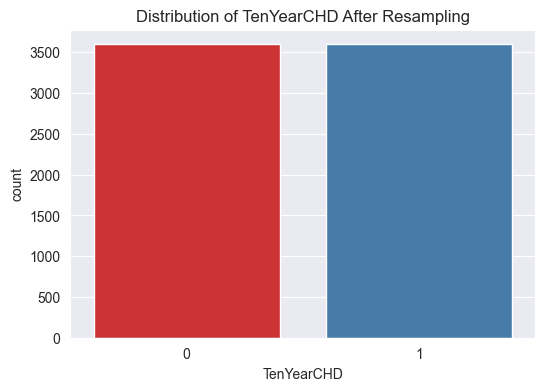

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Biểu đồ phân phối cho các cột số
numeric_cols = ["cigsPerDay", "BPMeds", "totChol", "BMI", "heartRate", "glucose"]
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_balanced[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

# 2. Biểu đồ tương quan (Heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = df_balanced.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# 3. Biểu đồ phân loại (Countplot) cho TenYearCHD
plt.figure(figsize=(6, 4))
sns.countplot(x='TenYearCHD', data=df_balanced, hue='TenYearCHD', palette='Set1', legend=False)
plt.title('Distribution of TenYearCHD After Resampling')
plt.show()